# Exercise 4: Fourier and Radon filtering
In this exercise we will look at seismic data in different domains and investigate how we can exploit behaviour of different kinds of noise in these domains to design filters.

Contents:
- Data
- Temporal Fourier transform
- f-k filtering
- Radon transform
- Parabolic Radon transform


In [2]:
using PyPlot, SegyIO, FFTW

**Data**

We use a single midpoint gather of the data used in the previous exercises: shot.segy (no big endian this time).

In [3]:
# Dowload and adapt path
shot = segy_read("/home/yzhang3198/Downloads/data_segy/shot.segy")

shot_data = Float32.(shot.data)

h = get_header(shot, "SourceX", scale=false) - get_header(shot, "GroupX", scale=false)
dt = get_header(shot, "dt")[1]/1e6
nt = get_header(shot, "ns")[1]
T = 0:dt:(nt -1)*dt

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=1705444, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/yzhang3198/.julia/packages/SegyIO/ak2qG/src/read/read_file.jl:26


0.0:0.004:4.0

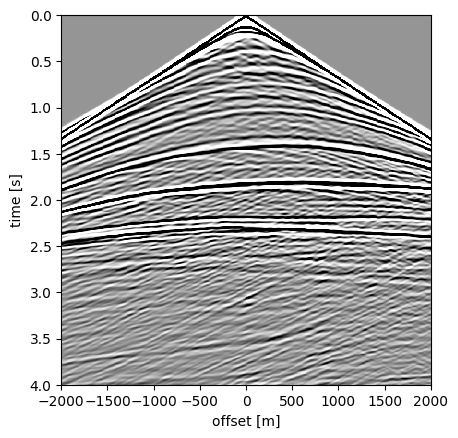

In [4]:
imshow(shot_data, vmin=-1, vmax=1, cmap="Greys", extent=[h[end], h[1], T[end], T[1]], aspect=1000)
xlabel("offset [m]");ylabel("time [s]");

**Temporal Fourier transform**

We can use fftrl to perform a Fourier transform along the temporal direction. The power spectrum (i.e., the absolute value of the transformed data) looks like

In [5]:
function fftrl(a, t, mode)
    # fft for real-valued vectors
    #
    # Tristan van Leeuwen, 2012
    # tleeuwen@eos.ubc.ca
    #
    # use:
    #   [b,f] = fftrl(a,t,mode)
    #
    # input:
    #   a - input data
    #   t - time vector
    #   mode: 1: forward, -1:inverse
    #
    # output:
    #   b - vector

    nt = length(t)
    dt = t[2] - t[1]
    nf = Int(floor(nt/2)) + 1
    tmax = t[end] - t[1]
    f = 0:1/tmax:.5/dt
    if mode == 1
        b = fft(a,1)
        b = b[1:nf,:]
    elseif mode == -1
        a = [a;conj(a[Int(ceil(nt/2)):-1:2,:])]
        b = ifft(a, 1)
        b = real(b)
    else
        error("Unknown mode")
    end

    return b, f
end


fftrl (generic function with 1 method)

In [6]:
Data_fh, f = fftrl(shot_data, T, 1)

(Complex{Float32}[0.6844337f0 + 0.0f0im 0.9717815f0 + 0.0f0im … 0.09694278f0 + 0.0f0im 0.004332781f0 + 0.0f0im; -0.70118594f0 - 0.4517814f0im -0.41232893f0 - 0.46060145f0im … -1.3077996f0 - 0.49731374f0im -1.4023542f0 - 0.48800778f0im; … ; -0.121281974f0 + 0.0007099677f0im -0.08637722f0 - 0.00040336605f0im … 0.1578058f0 - 0.0011496469f0im 0.11014599f0 - 0.0002730284f0im; -0.12202144f0 + 0.00059955195f0im -0.08491863f0 - 0.00023266952f0im … 0.15901898f0 - 0.0005980283f0im 0.10969794f0 - 0.00018512644f0im], 0.0:0.25:125.0)

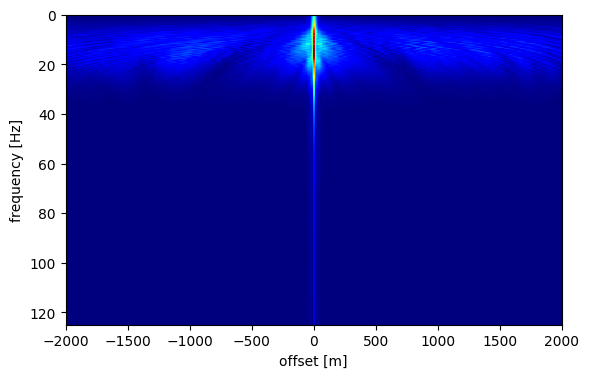

PyObject Text(24.000000000000007, 0.5, 'frequency [Hz]')

In [7]:
imshow(abs.(Data_fh), cmap="jet", extent=[h[end], h[1], f[end], f[1]], aspect=20)
xlabel("offset [m]");ylabel("frequency [Hz]")

**f-k filtering**
A Fourier transform along both time and offset direction is often referred to as an  transform. We can use fktran. The powerspectrum looks like

In [8]:
function fktran(a,t,x,mode)
    """
    f-k transform for real-values input.

    use:
        b, f, k = fktran(a,t,x,mode)

    input:
        a - matrix in t-x domain (nt x nx)
        t - time vector
        x - x vector
        mode - 1:forward, -1:inverse
    """

    nt = length(t)
    nx = length(x)

    dt = t[2]-t[1]
    dx = x[2] - x[1]

    xmax = x[end] - x[1]
    tmax = t[end] - t[1]


    f = 0:1/tmax:.5/dt
    k = -.5/dx:1/xmax:.5/dx

    nf = length(f)
    if mode == 1
        b = fft(a, 1)
        b = b[1:nf, :]
        b = ifft(b, 2)
        b = circshift(b,[0 ceil(Int, nx/2)-1]);
    elseif mode == -1
        b = circshift(a,[0 floor(Int, nx/2)+1]);
        b = fft(b, 2)
        b = ifft([b;conj(b[end:-1:2,:])], 1)
        b = real(b)
    else
        error("unknown mode")
    end
    return b, f, k
end

fktran (generic function with 1 method)

In [9]:
Data_fk, fk, kx = fktran(shot_data, T, h, 1)

(Complex{Float32}[0.002173217f0 + 0.37586603f0im -0.003716143f0 - 0.37589622f0im … -0.0037163715f0 + 0.37589744f0im 0.0021728363f0 - 0.37586543f0im; -0.06664165f0 + 0.37817085f0im 0.06513726f0 - 0.37864232f0im … -0.072564445f0 + 0.37711513f0im 0.07105575f0 - 0.37754175f0im; … ; 0.0033008547f0 + 0.40090138f0im -0.006969956f0 - 0.40087533f0im … -0.002999703f0 + 0.40091997f0im -0.0006929431f0 - 0.40090662f0im; 0.0019657868f0 + 0.40089262f0im -0.0056476546f0 - 0.4009117f0im … -0.0043306802f0 + 0.4009047f0im 0.000641849f0 - 0.4008996f0im], 0.0:0.25:125.0, 0.05:-0.00025:-0.05)

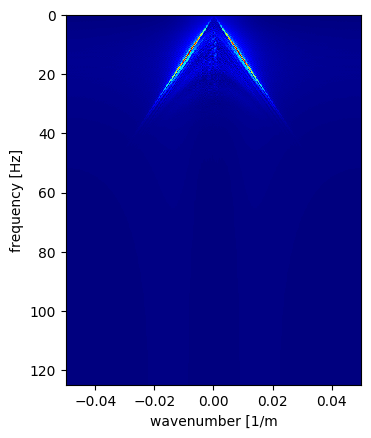

PyObject Text(23.999999999999993, 0.5, 'frequency [Hz]')

In [11]:
imshow(abs.(Data_fk), cmap="jet", extent=[kx[end], kx[1], f[end], f[1]], aspect=.001)
xlabel("wavenumber [1/m");ylabel("frequency [Hz]")

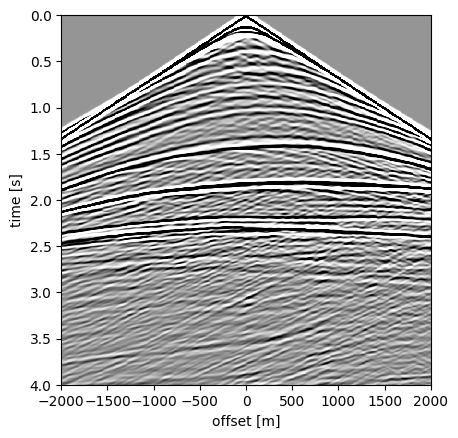

In [12]:
back, _, _ = fktran(Data_fk, fk, kx, -1)
imshow(back, vmin=-1, vmax=1, cmap="Greys", extent=[h[end], h[1], T[end], T[1]], aspect=1000)
xlabel("offset [m]");ylabel("time [s]");

In [13]:
size(shot_data)

(1001, 401)

# Questions:
Subsample the data in the offset direction and look at the Fourier transform. (Hint: use Data[:,1:n:end] and h[1:n:end] where n is the number of times you want to subsample).

- What do you see?
- Why is it important to have a good receiver sampling?

A filter is simply a multiplicative factor applied in some transform domain, typically \(f-h\) or \(f-k\), followed by an inverse transform. For example, a band-pass filter in the \(f-h\) domain filters out higher temporal frequencies by setting them to zero. A simple band-pass filter looks like this:



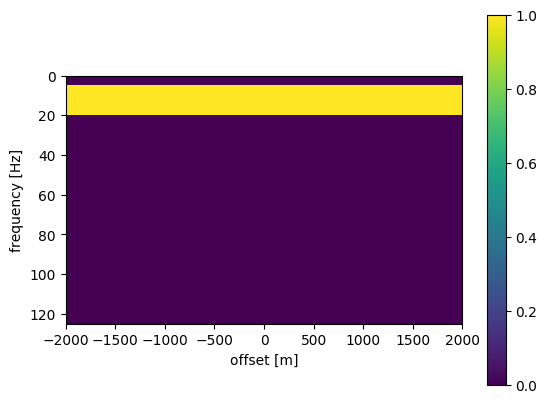

PyObject Text(24.000000000000007, 0.5, 'frequency [Hz]')

In [14]:
F_hp = ones(length(f),length(h))
F_hp[(f.<5) .| (f.>20.),:] .= 0

imshow(F_hp, extent=[h[end], h[1], f[end], f[1]], aspect=20)
colorbar()
xlabel("offset [m]");ylabel("frequency [Hz]")

The filtered data looks like this

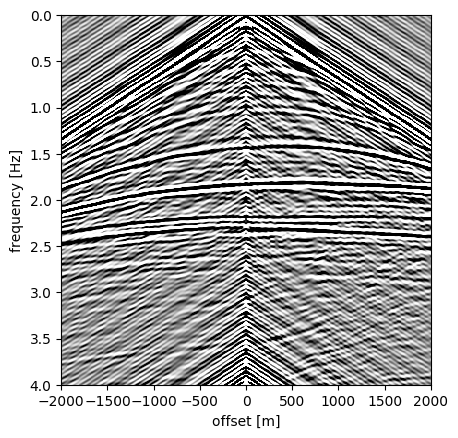

PyObject Text(24.000000000000007, 0.5, 'frequency [Hz]')

In [15]:
imshow(fftrl(F_hp.*Data_fh, f, -1)[1], cmap="Greys", vmin=-1, vmax=1, extent=[h[end], h[1], T[end], T[1]], aspect=1000)
xlabel("offset [m]");ylabel("frequency [Hz]")

Do you see the artifacts? A way to reduce these artifacts is to smooth the filter. We can do this by convolving the filter with a triangular smoothing kernel. This is implemented in the function smooth_2D. The result looks like this:

In [17]:
#using Pkg; Pkg.add("Images") of you do not alread yhave it
using Images

function smooth_2D(input, n1, n2)
    t1 = [1:n1; n1-1:-1:1]/n1^2
    t2 = [1:n2; n2-1:-1:1]/n2^2
    kernel = t1 * t2'
    return imfilter(input, centered(kernel))
end

smooth_2D (generic function with 1 method)

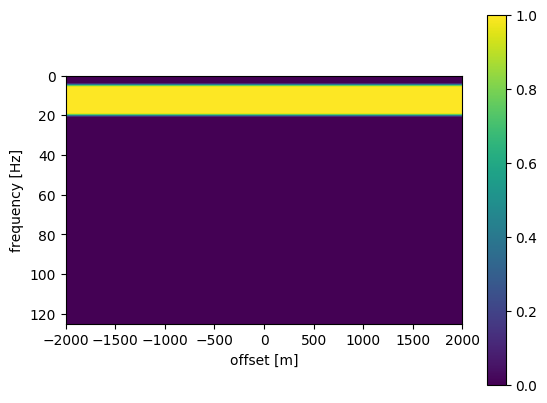

PyObject Text(24.000000000000007, 0.5, 'frequency [Hz]')

In [18]:
F_hp_smooth = smooth_2D(F_hp, 5, 1)
imshow(F_hp_smooth, extent=[h[end], h[1], f[end], f[1]], aspect=20)
colorbar()
xlabel("offset [m]");ylabel("frequency [Hz]")

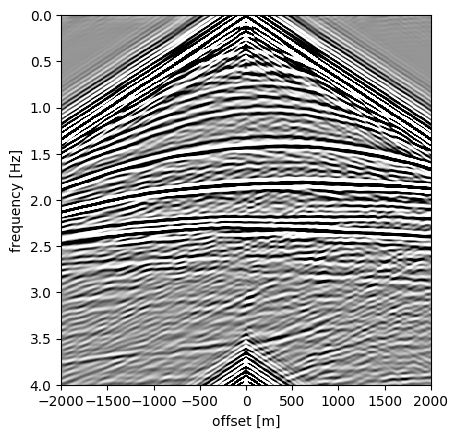

PyObject Text(24.000000000000007, 0.5, 'frequency [Hz]')

In [19]:
imshow(fftrl(F_hp_smooth.*Data_fh, f, -1)[1], cmap="Greys", vmin=-1, vmax=1, extent=[h[end], h[1], T[end], T[1]], aspect=1000)
xlabel("offset [m]");ylabel("frequency [Hz]")


A (smoothed) filter in the \(f-k\) domain may look like this

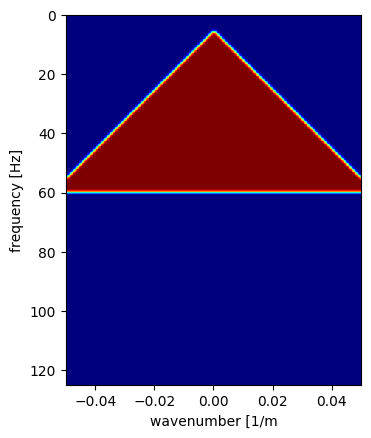

PyObject Text(23.999999999999993, 0.5, 'frequency [Hz]')

In [20]:
ff = [fi for fi in f, kxi in kx]
kkx = [kxi for fi in f, kxi in kx]
F_kx = zeros(length(fk),length(kx))

F_kx[(ff -1e3 * abs.(kkx) .> 5) .& (ff.<60)] .= 1

F_kx = smooth_2D(F_kx, 5, 5)

imshow(F_kx, cmap="jet", extent=[kx[end], kx[1], f[end], f[1]], aspect=.001)
xlabel("wavenumber [1/m");ylabel("frequency [Hz]")

# Questions

Describe how you would design filters to clean up shot gathers shot_noise1 and shot_noise2. (hint: look the f-k transform and compare to the orinigal data)
Try it and compare the result with the original shot gather.

# Radon transform
The Radon tranform performs sums along lines with different intercepts $\tau$) and slopes $p$. Hence, it is sometimes refered to as the $\tau-p$ transform in geophysics.

$\hat{d}(\tau,p) = \int\mathrm{d}h\, d(t + ph, h)$

The transform is implemented in the function lpradon.

To get an idea of what this transform does, we consider the simple example in lines.segy.



In [21]:
function lpradon(input, t, h, q, power, mode)
    # linear and parabolic Radon transform and its adjoint.
    #
    # Tristan van Leeuwen, 2012
    # tleeuwen@eos.ubc.ca
    #
    # use:
    #   out = lpradon(input,t,h,q,power,mode)
    #
    # input:
    #   input - input matrix of size (length(t) x length(h)) for forward, (length(t) x length(q)) for adjoint)
    #   t     - time vector in seconds 
    #   h     - offset vecror in meters
    #   q     - radon parameter
    #   power - 1: linear radon, 2: parabolic radon
    #   mode  - 1: forward, -1: adjoint
    #
    # output:            println(size(L))
    #   output matrix of size (length(t) x length(q)) for forward, (length(t) x length(h)) for adjoint)
    #
    #
    dt   = t[2] - t[1]
    nt   = length(t)
    nh   = length(h)
    nq   = length(q)
    nfft = 2*(Int64(nextpow(2,nt)))
    
    input_padded = zeros(nfft, size(input)[2])
    input_padded[1:size(input)[1], :] = input[:, :]
    
    
    if mode == 1
        input_padded  = fft(input_padded, 1)
        out = zeros(Complex{Float64}, nfft, nq)
        for k = 2:Int(floor(nfft/2))
            f = 2 .*pi*(k-1)/nfft/dt
            L = exp.(im*f*(h.^power)*q')
            tmp = conj((input_padded[k,:]' *L)[end:-1:1])
            out[k,:] = tmp
            out[nfft + 2 - k, :] = conj(tmp)
        end
        out = real(ifft(out, 1))
        out = out[1:nt, :]
    else
        input_padded  = fft(input_padded,1)
        out = zeros(Complex{Float64}, nfft, nh)
        for k = 2:Int(floor(nfft/2))
            f = 2 .*pi*(k-1)/nfft/dt
            L = exp.(im*f*(h.^power)*q')
            tmp = conj((input_padded[k,:]' *L')[end:-1:1])
            out[k,:] = tmp
            out[nfft+2-k,:] = conj(tmp)
        end
        out = real(ifft(out,1))
        out = out[1:nt, :]
    end
    return out
end

lpradon (generic function with 1 method)

In [22]:
# Dowload and adapt path
shot_radon = segy_read("/home/yzhang3198/Downloads/data_segy/lines.segy")

A = Float32.(shot_radon.data)

h = get_header(shot_radon, "SourceX", scale=false) - get_header(shot, "GroupX", scale=false)
dt = get_header(shot_radon, "dt")[1]/1e6
nt = get_header(shot_radon, "ns")[1]
T = 0:dt:(nt -1)*dt

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=1705444, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/yzhang3198/.julia/packages/SegyIO/ak2qG/src/read/read_file.jl:26


0.0:0.004:4.0

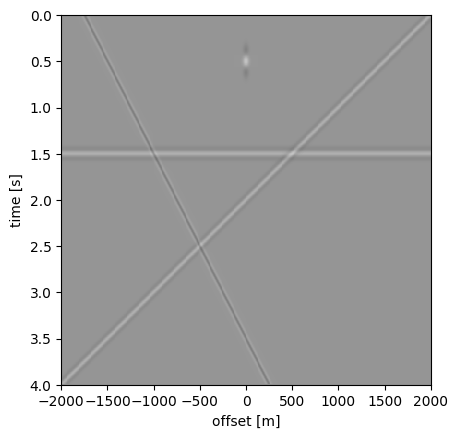

In [23]:
imshow(A, vmin=-.1, vmax=.1, cmap="Greys", extent=[h[end], h[1], T[end], T[1]], aspect=1000)
xlabel("offset [m]");ylabel("time [s]");

In [24]:
# which p-values
p = 1e-3.*(-3:.05:3)

# transform
A_tp = lpradon(A, T, h, p, 1, 1);

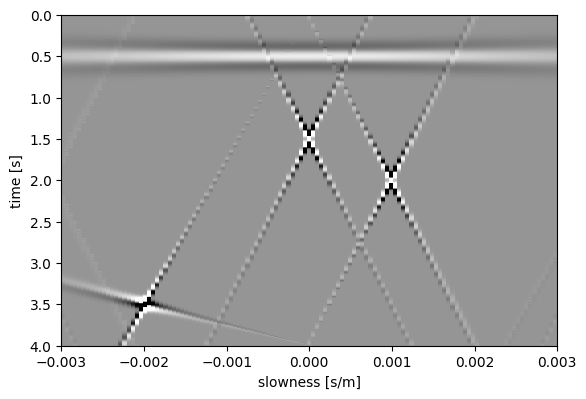

In [25]:
# plot
imshow(A_tp, vmin=-.25, vmax=.25, cmap="Greys", extent=[p[1], p[end], T[end], T[1]], aspect=.001)
xlabel("slowness [s/m]");ylabel("time [s]");


#  Questions
Can you interpret the results?
Describe how you would design `filters` in the $\tau-p$ domain to separate the different events.
Try it. Use the `adjoint` option of the transform to transform back to the physical domain.